In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!cp -r /content/drive/MyDrive/esmini.zip /content/esmini.zip
!unzip /content/esmini.zip

In [3]:
%%capture
!apt-get install -y xvfb x11-utils
!pip install ultralytics

In [4]:
import sys, os
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/xvfb -O ../xvfb
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'
!cp -r /content/drive/MyDrive/xvfb /content/xvfb
!chmod 755 /content/xvfb

Starting virtual X frame buffer: Xvfb.


In [5]:
%rm -r sim_loop

rm: cannot remove 'sim_loop': No such file or directory


In [6]:
!/content/xvfb start
%cd /content/esmini
!chmod 755 bin/esmini
%cd /content
!git clone https://github.com/patrickw16/sim_loop.git

Starting virtual X frame buffer: Xvfb.
/content/esmini
/content
Cloning into 'sim_loop'...
remote: Enumerating objects: 3748, done.
remote: Counting objects: 100% (700/700), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 3748 (delta 580), reused 608 (delta 511), pack-reused 3048 (from 1)
Receiving objects: 100% (3748/3748), 88.57 MiB | 38.69 MiB/s, done.
Resolving deltas: 100% (3229/3229), done.


In [7]:
!git clone https://...@github.com/patrickw16/odd_coverage.git
%cd odd_coverage
!git checkout ThreeDimensional
%cd /content

Cloning into 'odd_coverage'...
remote: Enumerating objects: 2809, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 2809 (delta 26), reused 28 (delta 11), pack-reused 2758 (from 1)
Receiving objects: 100% (2809/2809), 44.42 MiB | 24.19 MiB/s, done.
Resolving deltas: 100% (2232/2232), done.
Updating files: 100% (4838/4838), done.
/content/odd_coverage
Branch 'ThreeDimensional' set up to track remote branch 'ThreeDimensional' from 'origin'.
Switched to a new branch 'ThreeDimensional'
/content


In [8]:
%%capture
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
!pip install latex
!sudo apt install cm-super

I will break since no more clusters in red zone.
I successfully finished. There are 1 successful attempts.
Gradient:-1.3984105891414549
b value:0.035112083716517146
[[47.89435447 26.37129911  5.13096009]
 [16.87678606 25.54547259  5.38980978]
 [32.92125721 28.06443479  3.1817786 ]
 [41.72067459 38.59351544  6.83125475]
 [21.3071283  14.55104468  4.75938238]
 [56.06093177 38.47000736  5.13752014]
 [16.03579594 20.79639002  6.22368248]
 [56.17014456 27.94480357  3.35888846]
 [27.24815272 17.45247202  3.89104449]
 [43.62154224 37.46798237  5.33074471]
 [24.1983301  30.01896998  5.04836454]
 [43.18950004 32.06847594  6.25948649]
 [39.64463856 26.25240672  4.43306498]
 [21.52258312 35.06870416  6.69724464]
 [42.90757875 23.77002862  6.00315311]
 [23.34911564 24.71247014  4.00266676]
 [51.31401423 23.98565561  4.15782183]
 [46.76510269 34.64629831  4.06256962]
 [46.81319865 17.33319152  3.18765782]
 [14.66737593 22.27198464  4.5514948 ]
 [14.97448152 12.82138585  6.22752551]
 [30.43213815 26

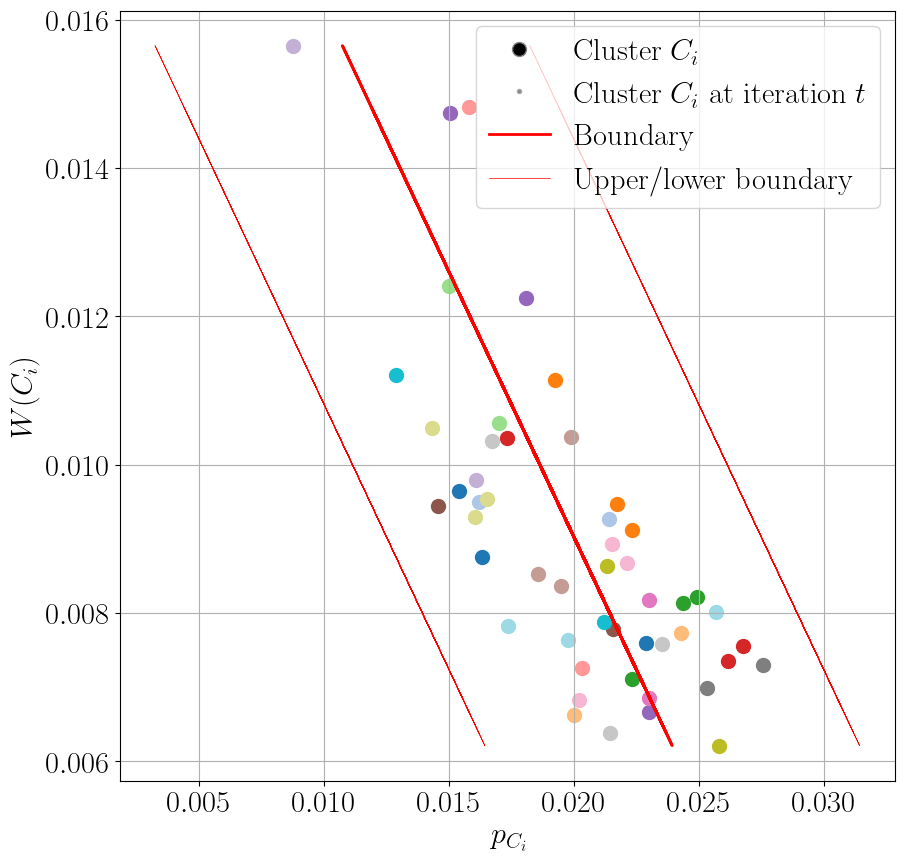

In [31]:
# Generate variance bounded test cases
import numpy as np
from PIL import Image
from IPython.core.display import SVG
from sim_loop.evaluation.cube_based_evaluation import CubeBasedEvaluation
from odd_coverage.odd_coverage.coverage_param_lvl.coverage_param_lvl import CoverageParamLvl

#Generate evaluation points:
my_coverage_param = CoverageParamLvl(
                    number_of_test_values=50,
                    trace_epsilon=0.0075,
                    epsilon_buffer=0.005,
                    number_of_attempts=1,
                    combined_points_data_path='./sim_loop/evaluation/variance_bounded_testing_method/data/prior/prior_points_s_delta_v_delta_ego_max_dec_-3_10_0.npy')

param_values, cov_contribution, updated_cluster_traces, adapted_kmeans_labels, re_sampled_scaled, scaler, weighted_within_variance = my_coverage_param.get_optimised_values(plot_path='/content/var_poc_3d_example.svg')

print(param_values)

points = scaler.inverse_transform(re_sampled_scaled)

#SVG(filename='/content/var_poc_3d_example.svg')

In [32]:
# Generate scenarios
from sim_loop.evaluation.variance_bounded_testing_method.simulation.parameter_set_generation import modify_xml

for idx, parameter in enumerate(param_values):

    new_s_delta = param_values[idx, 0]  # New value for s_delta
    new_v_delta = param_values[idx, 1]  # New value for v_delta
    new_a_dec = param_values[idx, 2]  # New value for a_dec

    input_file = '/content/sim_loop/scenarios/cut-in.xosc'  # Replace with your input file path
    output_file = f'/content/sim_loop/scenarios/variance_bounded/{idx}_{new_a_dec}_cut-in.xosc'  # Replace with your desired output file path

    modify_xml(input_file, output_file, new_s_delta, new_v_delta)

In [33]:
from multiprocessing.pool import ThreadPool
import subprocess
import sys
import os.path

# globals
launched = 0
done = 0
n_runs = 0

def print_status():
    print('Launched: {}/{} Done: {}'.format(launched, n_runs, done), end='\r', flush=True)

def launch_scenario(index):
    global launched
    global done
    launched += 1
    print_status()
    p = subprocess.run(
        ['python'] + ['/content/sim_loop/evaluation/variance_bounded_testing_method/simulation/variance_bounded_colab_execution.py'] + ['--window'] + [str(60)] + [str(60)] + [str(800)] + [str(400)] + ['--headless'] + ['--osc'] + [f'/content/sim_loop/scenarios/variance_bounded/{str(index)}_{str(param_values[index, 2])}_cut-in.xosc'] + ['--logfile_path'] + [f'/content/{str(index)}_log.txt'],
    )

    done += 1
    print_status()


if __name__ == '__main__':

    n_runs = len(param_values)
    print_status()

    with ThreadPool() as p:
        p. map(launch_scenario, range(n_runs))

    print()

In [ ]:
# analyze logs and store results

In [34]:
%mkdir logs

In [35]:
# prompt: move all log files to logs folder

import shutil
import glob

# Move all log files to the logs folder
log_files = glob.glob("*.txt")  # Find all files ending with .log in the current directory
for log_file in log_files:
  try:
    shutil.move(log_file, "logs/")  # Move the file to the logs/ directory
  except FileNotFoundError:
    print(f"Error: The 'logs' directory does not exist.")
  except shutil.Error as e:
    print(f"Error moving file {log_file}: {e}")

In [39]:
# prompt: zip the logs folder

import shutil
import os

def zip_logs():
  # Check if the logs directory exists
  if os.path.exists("logs"):
    try:
      shutil.make_archive("logs", "zip", "logs")
      print("Logs folder zipped successfully to logs.zip")
    except Exception as e:
      print(f"Error zipping logs folder: {e}")
  else:
    print("Error: logs folder not found.")

zip_logs()

Logs folder zipped successfully to logs.zip


In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt

log_file = "logs"
log_directory = os.path.join(os.path.expanduser('~'), f"/content/{log_file}")

# Get a sorted list of all .txt files in the directory
log_files = sorted([f for f in os.listdir(log_directory) if f.endswith('.txt')])

# Initialize a list to hold all parameter dictionaries
all_parameters = []

# Loop through each log file and read its contents
for filename in log_files:
    log_file_path = os.path.join(log_directory, filename)

    # Open the log file and read its contents
    with open(log_file_path, 'r') as file:
        log_contents = file.readlines()  # Read lines into a list

    # Initialize a dictionary to hold parameters
    parameters = {}
    parameters_started = False
    collision_detected = False  # Flag to check for collision line

    # Loop through the lines to find "6 parameters:" and extract parameters
    for line in log_contents:
        if "6 parameters:" in line:
            parameters_started = True  # Start reading parameters
            continue  # Skip the line with "6 parameters:"

        # Check for the collision line
        if "Collision" in line:
            collision_detected = True

        if parameters_started:
            # Split the line into key and value
            if '=' in line:
                key, value = line.split('=')
                key = key.replace(' ', '')
                value = value.replace(' ', '')
                value = value.replace("\n", "")
                parameters[key.strip()] = float(value.strip())  # Store as float
                if key == "EgoStartS":
                    parameters_started = False

    # Add collision information to the parameters dictionary
    parameters['CollisionDetected'] = collision_detected
    parameters['Filename'] = filename  # Optionally include the filename

    # Append the parameters dictionary to the list
    all_parameters.append(parameters)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(all_parameters)

# Save the DataFrame to a CSV file
output_file = f'{log_directory}/compiled_log_data.csv'
df.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")

Data saved to /content/logs/compiled_log_data.csv


In [37]:
import numpy as np
import pandas as pd
from sim_loop.evaluation.cube_based_evaluation import CubeBasedEvaluation, fail_ratio

#Load GT data:
gt_cubes_sizes = np.load('/content/sim_loop/evaluation/gt_analysis/data/gt_cube_sizes.npy')
gt_pass_fail = np.load('/content/sim_loop/evaluation/gt_analysis/data/gt_pass_fail.npy')
gt_sub_cube_centers = np.load('/content/sim_loop/evaluation/gt_analysis/data/gt_sub_cube_centers.npy')

# Order the sim log to align the order of the simulation runs with the param values (test case values)
df_sim = pd.read_csv('/content/logs/compiled_log_data.csv')
df_sim['FileNumber'] = df_sim['Filename'].str.extract(r'(\d+)').astype(int) # Extract the first value from the Filename
result = df_sim[['FileNumber', 'CollisionDetected']]
ordered_sim_logs = result.sort_values(by='FileNumber')
ordered_sim_logs.reset_index(drop=True, inplace=True)
pass_fail_logs = ordered_sim_logs['CollisionDetected'].to_numpy()

points = points
groups = adapted_kmeans_labels.astype(int)
param_values = param_values

#print(groups)
#print(param_values[:,0]) # -> s_delta

pass_fail_points = np.zeros(len(groups))
for i in range(len(groups)):
    group = groups[i]
    pass_fail_points[i] = pass_fail_logs[group]

pass_fail = pass_fail_points.astype(bool)

#print(pass_fail_points)

#alternative
points = param_values
pass_fail = pass_fail_logs
groups = np.arange(len(param_values))

#Compare
comparison_gt_evaluation = CubeBasedEvaluation(gt_cube_sizes=gt_cubes_sizes,
                                            gt_sub_cube_centers=gt_sub_cube_centers,
                                            gt_pass_fail=gt_pass_fail)
sub_cubes_with_points = comparison_gt_evaluation.evaluate_gt_cubes_based_on_eval_points(points=points,
                                                                                        groups=groups,
                                                                                        pass_fail=pass_fail)

sub_cubes_with_points = comparison_gt_evaluation.assign_all_sub_cubes(sub_cubes_with_points=sub_cubes_with_points,
                                                                    points=points,
                                                                    groups=groups,
                                                                    pass_fail=pass_fail)

#comparison_gt_evaluation.plot_cubes(sub_cubes_with_points=sub_cubes_with_points,
#                                  points=points)

metric = comparison_gt_evaluation.calculate_comparison_metric(sub_cubes_with_points=sub_cubes_with_points)
gt_fail_ratio = fail_ratio(gt_pass_fail)
eval_fail_ratio = fail_ratio(np.array(pass_fail))
fail_ratio_difference = (fail_ratio(gt_pass_fail)-fail_ratio(np.array(pass_fail)))*100
abs_fail_ratio_difference = np.abs(fail_ratio_difference)
number_of_test_cases = len(param_values[:,0])

print(f'Metric:{metric}')



Sub-cube 1068 contains points from group [np.int64(0)] (original cube center: [48. 26.  5.]): [array([47.89435447, 26.37129911,  5.13096009])]
Sub-cube 1200 contains points from group [np.int64(1)] (original cube center: [16. 26.  5.]): [array([16.87678606, 25.54547259,  5.38980978])]
Sub-cube 94 contains points from group [np.int64(2)] (original cube center: [32. 28.  3.]): [array([32.92125721, 28.06443479,  3.1817786 ])]
Sub-cube 1853 contains points from group [np.int64(3)] (original cube center: [42. 38.  7.]): [array([41.72067459, 38.59351544,  6.83125475])]
Sub-cube 1246 contains points from group [np.int64(4)] (original cube center: [22. 14.  5.]): [array([21.3071283 , 14.55104468,  4.75938238])]
Sub-cube 1145 contains points from group [np.int64(5)] (original cube center: [56. 38.  5.]): [array([56.06093177, 38.47000736,  5.13752014])]
Sub-cube 1613 contains points from group [np.int64(6)] (original cube center: [16. 20.  6.]): [array([16.03579594, 20.79639002,  6.22368248])]
S

In [40]:
np.save('/content/points.npy', points)
np.save('/content/adapted_kmeans_labels.npy', adapted_kmeans_labels)
np.save('/content/param_values.npy', param_values)

In [30]:
%rm -r logs
%rm -r sim_loop/scenarios/variance_bounded

In [ ]:
# for looping this (or even parallelize it?)
    # decide which prior to use
    # generate test case with variance bounded method
    # generate folder for scenarios
    # generate scenarios (based on test cases)
    # simulate test cases
    # create folder for logs
    # move logs to folder
    # create csv out of logs
    # calculate metric
    # store in dictionary - additionally using the prior paramters
    # remove folder with logs
    # remove folder with scenarios